## Fitness Tracker Analysis - Part 3

**Continued from Part 2 here:**

`/notebooks/nk-fitness-tracker-p2-outlier-removal.ipynb`

### 3.1 - Feature Engineering

The next step is to prepare each feature to get the best results possible from modeling. There are multiple steps in the feature engineering process, including imputation, noise reduction (smoothing), principal component analysis (PCA), etc. 

In [20]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [21]:
# Set up the plotting styles
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [22]:
# Load the data with outliers removed
df = pd.read_pickle("../data/interim/02_data_outliers_removed_chauvenets.pkl")

# Assign the predictor columns (sensor data)
predictor_columns = df.columns[:6]

### 3.2 - Imputation

I've decided to impute missing values by interpolating the gap between known values. This is simply done by calling the `interpolate()` function. 

In [23]:
for col in predictor_columns:
    df[col] = df[col].interpolate()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


### 3.3 - Calculate the Set Duration

Before we go further with smoothing the data, we want to know how long each set usually lasts. Then we can apply a lowpass filter to smooth out high-frequency noise without oversmoothing repetitions with a set.

In [24]:
for s in df["set"].unique():
    set_start = df[df["set"] == s].index[0]
    set_stop = df[df["set"] == s].index[-1]

    set_duration = set_stop - set_start
    df.loc[(df["set"] == s), "set_duration"] = set_duration.seconds

duration_df = df.groupby(["category"])["set_duration"].mean()

print(f"Average duration of a rep in a heavy set: {duration_df.iloc[0] / 5}")
print(f"Average duration of a rep in a medium set: {duration_df.iloc[1] / 10}")

Average duration of a rep in a heavy set: 2.9487001733102254
Average duration of a rep in a medium set: 2.4942528735632186


### 3.4 - Butterworth Low-pass Filter

Now that we know how long each rep is (2.5-3 seconds), we can apply a butterworth low-pass filter to smooth out the noisy data to make it more coherent for the models to train only on the big movements.

A visual example of applying a lowpass filter can be seen here:

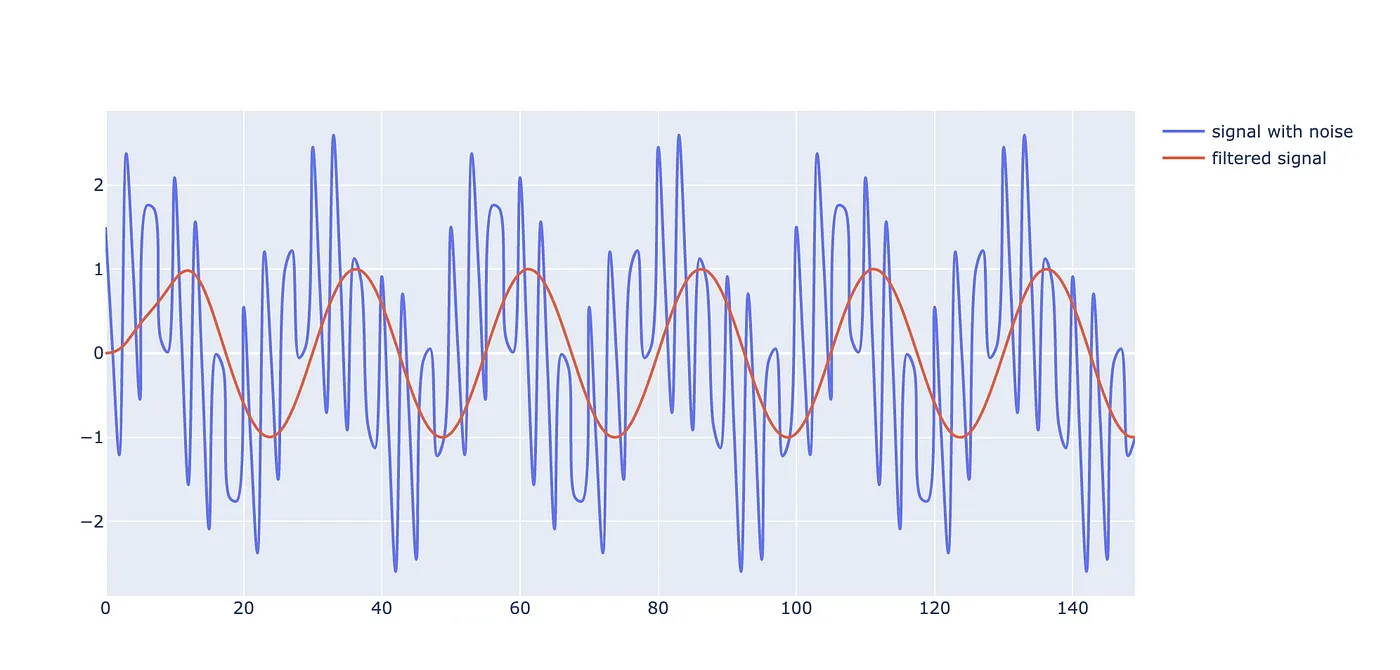

Source: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

More information about this method can be found here:

*Hoogendoorn, M., & Funk, B. (2018). Machine learning for the quantified self. On the art of learning from sensory data.*

In [25]:
# Import the library containing the source code for thelowpass filter
from src.features.DataTransformation import LowPassFilter

# Create an instance of the LowPassFilter class
LowPass = LowPassFilter()

# First make a copy of the dataframe, so we don't break the original
df_lowpass = df.copy()

Before we apply the lowpass filter, set the sampling frequency to 5 Hz and assign a cutoff value between 1 and 2:

In [26]:
fs = 1000 / 200  # sampling frequency (200ms)
cutoff = 1.3  # test this value and adjust as needed

Now apply the lowpass filter to the `acc_y` column:

In [30]:
# Apply the low pass filter to the acc_y column
df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)

Compare the new column vs the original to check the effect of the low pass filter in the following visualization (for deadlifts):

dead


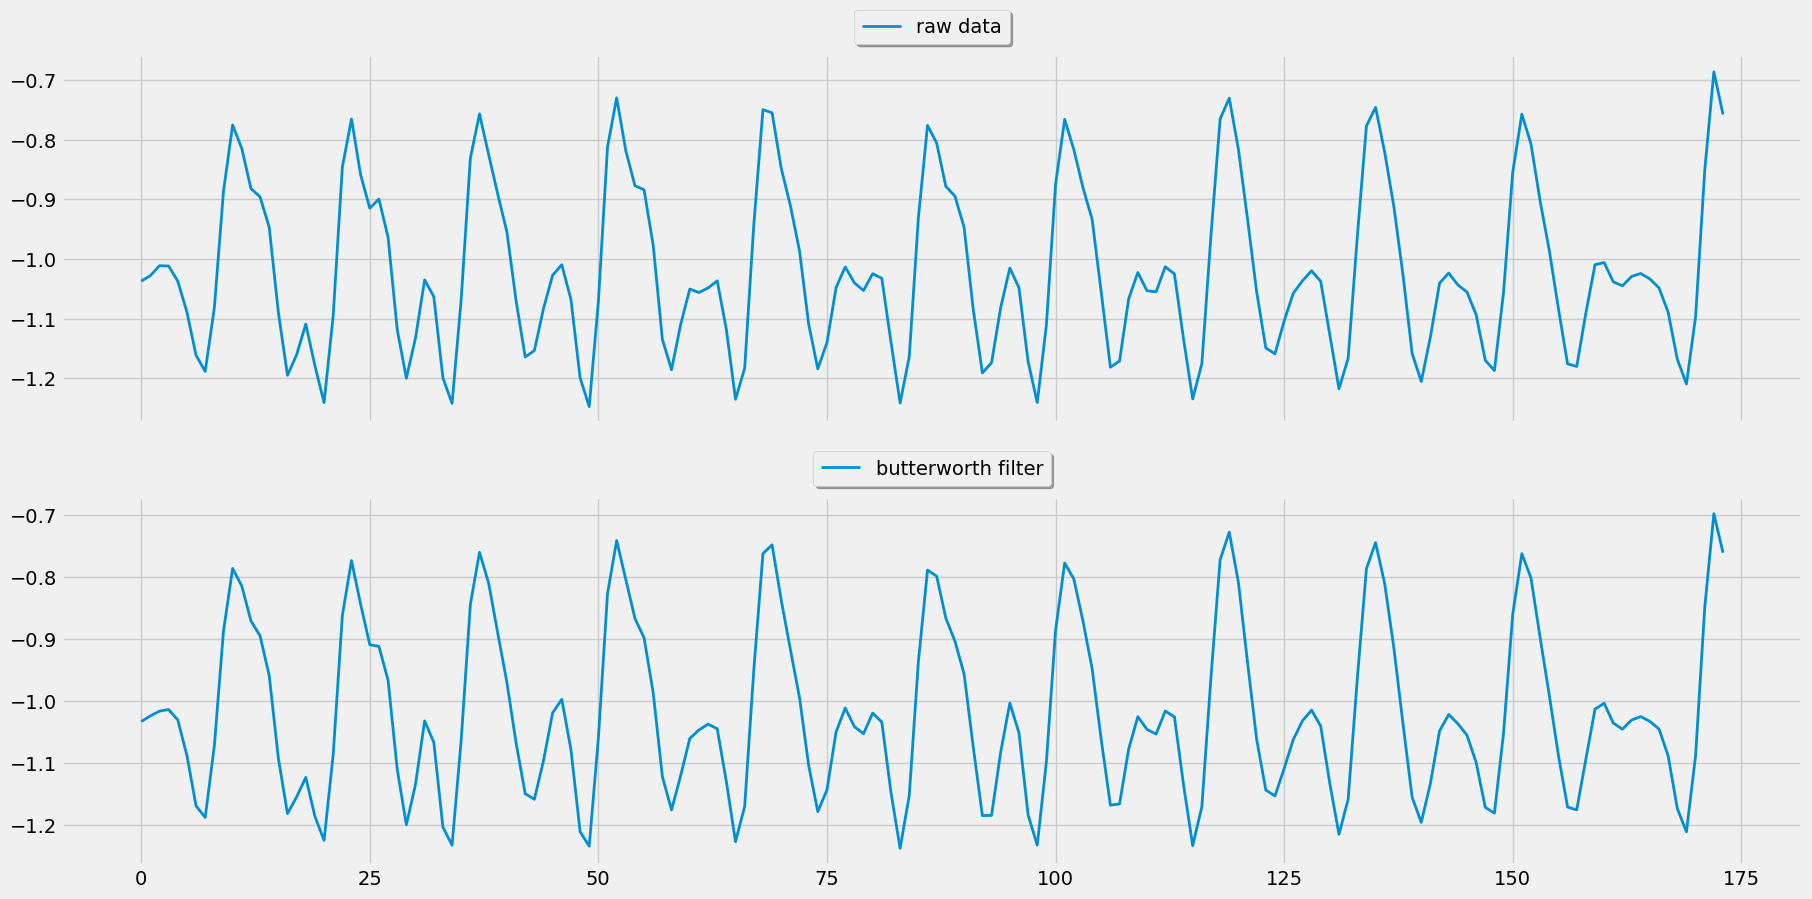

In [31]:
subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"][0])

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

Once we are satisifed with the cutoff value, apply the lowpass filter to all predictor columns:

In [32]:
# Once the cutoff value is selected, apply the filter to all columns
for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)

    # Overwrite the original column with the low pass filtered column
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

### 3.5 - Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique where we use the elbow technique can be used to determine the optimal number of components to use when conducting PCA. This helps determine the number of components that explain the most variance for the model to train on.

My favorite YouTube video that explains PCA most clearly is Josh Starmer's StatQuest PCA explainer:

https://www.youtube.com/watch?v=FgakZw6K1QQ

In [36]:
# Import the library containing the source code for PCA
from src.features.DataTransformation import PrincipalComponentAnalysis

To be continued...
